## Ждем обратную связь

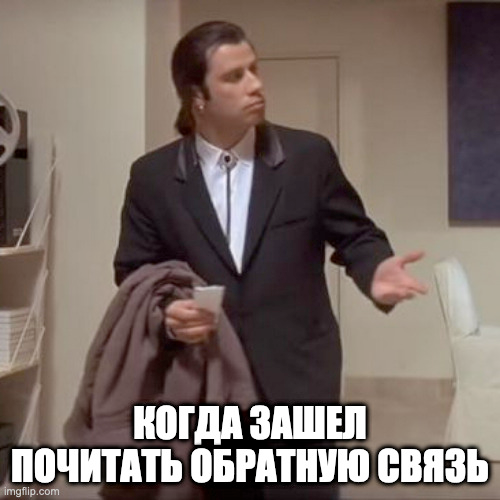

# Recap


## На прошлом занятии

Реализовали MLP на pytorch. Но использовали pytorch как черный ящик.
Мы не знаем, как он работает, каким магическим образом вычисляет градиенты?

```python
class MLP(nn.Module):
    def __init__(self):
        super().__init__()

        # https://pytorch.org/docs/stable/generated/torch.nn.Linear.html
        self.linear_in  = nn.Linear(2, 16)
        self.linear_mid = nn.Linear(16, 16)
        self.linear_out = nn.Linear(16, 1)

        # https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html
        self.activation = nn.ReLU()

        return

    def forward(self, x_coordinates):
        # x_coordinates ~ [ batch_size, 2 ]

        latents = self.activation(self.linear_in(x_coordinates)) # [ batch_size, 16 ]
        latents = self.activation(self.linear_mid(latents))      # [ batch_size, 16 ]
        scores = self.linear_out(latents)                        # [ batch_size, 1 ]
        scores = scores[:, 0]                                    # [ batch_size ]

        return scores

```


## Что мы запомнили на лекции? 🤷

* нейросеть -- это сложная функция (с параметрами), которая может быть представлена как композиция простых функций
* оптимизируем с помощью градиентного спуска

Чтобы сделать шаг оптимизации, нам нужно посчитать градиенты (спасибо, кэп).

Теоретически, мы можем посчитать градиенты руками для заданной нейронки. Но это будет трудоемко. И если немного поменять архитектуру сети, придется все пересчитывать.

Чтобы не заниматься аналитическим вычислением градиента, можем написать autograd! Этот подход лежит в основе `Pytorch`


# Зачем мы пилим автоград? 🤖

Чтобы не считать градиенты вручную!

# Как работать с автоградом? 🪄

От автограда нам нужно 2 вещи: forward и backward pass.

### **forward pass** --- на этом этапе идет вычислений сети, по сути, в формулу сети подставляются конкретные входные переменные и конкретные параметры
$$ F(x, p) = y $$

* $ x $ -- входные данные, например, вектор с фичами картинки
* $ p $ -- параметры модели, их мы обучаем
* $ y $ -- результат вычисления модели. Физический смысл $y$ зависит от задачи. Но например, это можнет быть вероятностью какого-то класса в случае задачи классификации


### **backward pass** --- процесс вычисления градиентов по параметрам модели

$$ \frac {\partial F(x, p)} {\partial p} $$


# Backpropagation + Chain rule = ❤️

Слайд из лекции

<!-- \begin{align*}
F &= (a + b) c  \\
 q &= a + b  \\
 F &= q c
\end{align*}
---

---

\begin{align*}
\frac { \partial F} {\partial a} &= \frac { \partial f } { \partial q } \frac { \partial q } { \partial a } = c \cdot 1 \\
\frac {\partial F} {\partial b} &= \frac { \partial f } { \partial q } \frac { \partial q } { \partial b } = c \cdot 1 \\
 \frac {\partial F} {\partial c} &= q
\end{align*} -->

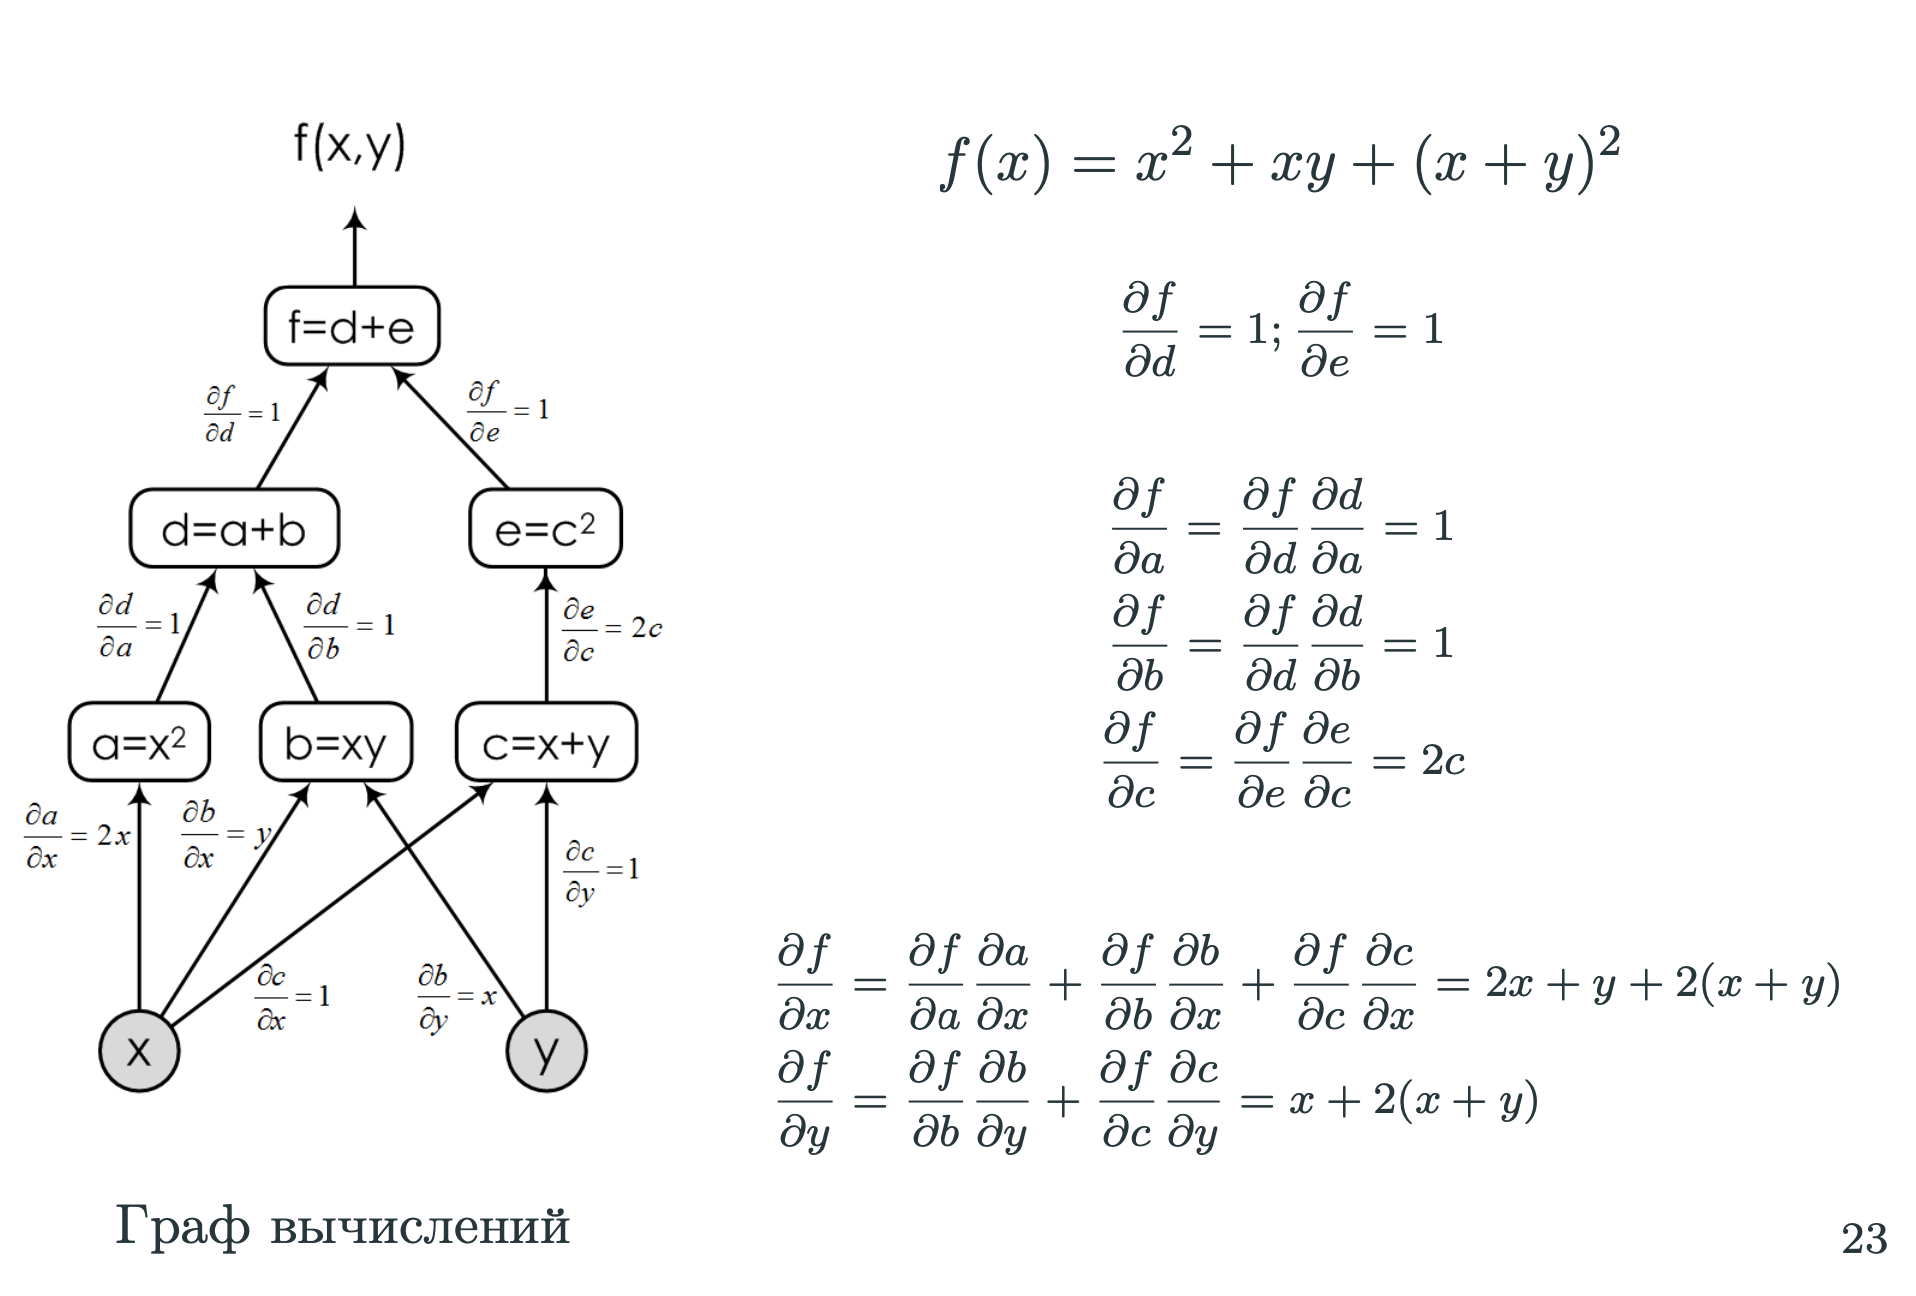

# Рассмотрим пример, как работает autograd в `PyTorch`

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import random
import torch.nn as nn
import torch

### Как на градиенты влияет сложение?

\begin{align*}
c &= a + b \\
\frac {\partial c} {\partial a} &= 1 \\
\frac {\partial c} {\partial b} &= 1
\end{align*}


In [2]:
a = torch.Tensor([10.])
a.requires_grad = True

b = torch.Tensor([1.])
b.requires_grad = True

с = a + b
с.backward()

a.grad, b.grad

(tensor([1.]), tensor([1.]))

### Как на градиенты влияет умножение?

\begin{align*}
c &= a b \\
\frac {\partial c} {\partial a} &= b \\
\frac {\partial c} {\partial b} &= a
\end{align*}

In [4]:
a = torch.Tensor([10.])
a.requires_grad = True

b = torch.Tensor([1.])
b.requires_grad = True

с = a * b
с.backward()

a.grad, b.grad

(tensor([1.]), tensor([10.]))

# Мы готовы сделать свой автоград!

## RuLU (Rectified linear unit)

В семинаре мы будем использовать ReLU в качестве ф-ии активации

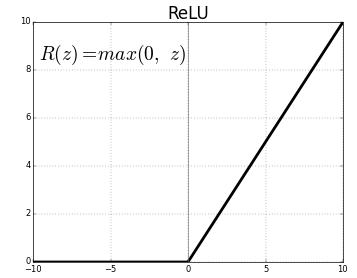


#### Python magiс methods


```python
Value(1) + Value(2)

# превращается в
Value(1).__add__(Value(2))  
```


Based on [karpathy's micrograd](https://github.com/karpathy/micrograd)

Нейронная сеть -- это просто формула с большим количеством параметров, собранная из очень простых примитивов.
Давайте пройдем путь от идеи до реализации в коде, используя возможности современных языков программирования.


## Proof of concept


Идея: давайте писать код вычислений, по нему строить вычислительный граф, градиенты считать по графу.

Формат представления графа под капотом не важен, давайте определимся с интерфейсами.


In [5]:
class Value:
    """
    Stores a single scalar value and its gradient like `torch.Tensor`
    """

    def __init__(self, data, inputs=(), name=''):
        self.data = data
        self.grad = 0

        # internal variables used for autograd graph construction
        #
        self._backward = lambda: None

        # для правильной работы backward нам нужно посчитать градиенты в правильном порядке
        # для этого мы будем обходить построенный граф от вершины к листьям
        # в inputs мы храним параметры, с помощью которых было вычислено текущее `Value`
        self.inputs = set(inputs)

        self.name = name # the op that produced this node, for graphviz / debugging / etc

    # out = self + other
    # частные производные:
    # d out / d self = 1
    # d out / d other = 1
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)

        out = Value(self.data + other.data, inputs=(self, other), name='+')

        def _backward():
            self.grad += out.grad * 1
            other.grad += out.grad * 1
        out._backward = _backward

        return out

    # out = self * other
    # частные производные:
    # d out / d self = other
    # d out / d other = self
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, inputs=(self, other), name='*')

        def _backward():
            other.grad += self.data * out.grad
            self.grad += other.data * out.grad

        out._backward = _backward

        return out

    # out = self ** other
    # частные производные:
    # d out / d self = (other - 1) * self ** other
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, inputs=(self,), name=f'**{other}')

        def _backward():
            self.grad += out.grad * other * self.data ** (other - 1)

        out._backward = _backward

        return out

    # relu(self) = max(0, self)
    # d out / d self = 0, если self < 0
    # d out / d self = 1, если self >= 0
    def relu(self):
        out = Value(0 if self.data <= 0 else self.data, inputs=(self,), name='ReLU')

        def _backward():
            if out.data <= 0:
                self.grad += 0
            else:
                self.grad += 1 * out.grad

        out._backward = _backward

        return out

    def backward(self):

        # topological order all of the children in the graph
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v.inputs:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        # go one variable at a time and apply the chain rule to get its gradient
        self.grad = 1
        for v in reversed(topo):
            v._backward()

    def __neg__(self): # -self
        return self * -1

    def __radd__(self, other): # other + self
        return self + other

    def __sub__(self, other): # self - other
        return self + (-other)

    def __rsub__(self, other): # other - self
        return other + (-self)

    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __rtruediv__(self, other): # other / self
        return other * self**-1

    def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad})"


a = Value(1.0, name='a')
b = Value(2.0, name='b')

c = a + b
z = a * c
d = z - b

print([x.grad for x in [a, b, c, z]])
z.backward()
print([x.grad for x in [a, b, c, z]])

[0, 0, 0, 0]
[4.0, 1.0, 1.0, 1]


# Visualization

Для наглядности и отладки графов может пригодиться визуализация вычислительного графа:

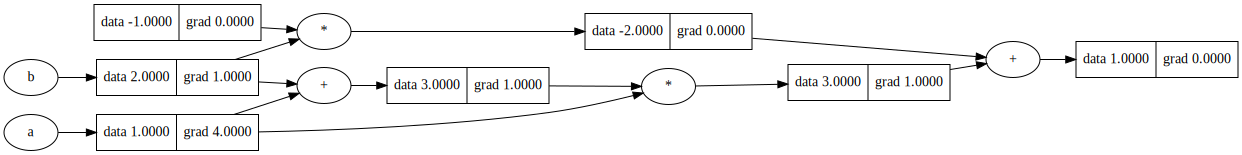

In [6]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v.inputs:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges


def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})

    for n in nodes:
        dot.node(name=str(id(n)), label = "{ data %.4f | grad %.4f }" % (n.data, n.grad), shape='record')
        if n.name:
            dot.node(name=str(id(n)) + n.name, label=n.name)
            dot.edge(str(id(n)) + n.name, str(id(n)))

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2.name)

    return dot


dot = draw_dot(d)
dot

# Тестирование

По-хорошему для проверки корректности нам стоит завести unit-тесты на каждую функцию/ветку выполнения.
Это будет работать, поскольку вся логика разбита на небольшие изолированные части.

Но для простоты мы можем просто сравнить результаты работы с эталоном. В качестве эталона можно взять pytorch (В курсе мы будем пользоваться именно им).


In [7]:
import torch

def test_sanity_check():

    x = Value(-4.0)
    z = 2 * x + 2 + x
    q = z.relu() + z * x
    h = (z * z).relu()
    y = h + q + q * x
    y.backward()
    xmg, ymg = x, y

    x = torch.Tensor([-4.0]).double()
    x.requires_grad = True
    z = 2 * x + 2 + x
    q = z.relu() + z * x
    h = (z * z).relu()
    y = h + q + q * x
    y.backward()
    xpt, ypt = x, y

    # forward pass went well
    assert ymg.data == ypt.data.item()
    # backward pass went well
    assert xmg.grad == xpt.grad.item(), f"{xmg.grad} == {xpt.grad.item()}"

def test_more_ops():

    a = Value(-4.0)
    b = Value(2.0)
    c = a + b
    d = a * b + b**3
    c += c + 1
    c += 1 + c + (-a)
    d += d * 2 + (b + a).relu()
    d += 3 * d + (b - a).relu()
    e = c - d
    f = e**2
    g = f / 2.0
    g += 10.0 / f
    g.backward()
    amg, bmg, gmg = a, b, g

    a = torch.Tensor([-4.0]).double()
    b = torch.Tensor([2.0]).double()
    a.requires_grad = True
    b.requires_grad = True
    c = a + b
    d = a * b + b**3
    c = c + c + 1
    c = c + 1 + c + (-a)
    d = d + d * 2 + (b + a).relu()
    d = d + 3 * d + (b - a).relu()
    e = c - d
    f = e**2
    g = f / 2.0
    g = g + 10.0 / f
    g.backward()
    apt, bpt, gpt = a, b, g

    tol = 1e-6
    # forward pass went well
    assert abs(gmg.data - gpt.data.item()) < tol
    # backward pass went well
    assert abs(amg.grad - apt.grad.item()) < tol
    assert abs(bmg.grad - bpt.grad.item()) < tol


test_sanity_check()
test_more_ops()

# Модули

Как уже обсуждалось на лекции, удобно собирать отдельные значения в вектора и матрицы, а однотипные операции делать матричными.

Для решения практических задач опишите несколько простых модулей:

In [14]:
class Module():
    def zero_grad(self):
        for p in self.parameters():
            p.grad = 0

    def parameters(self):
        return []

class Neuron(Module):

    def __init__(self, nin, nonlin=True):
        self.w = [Value(random.uniform(-0.1,0.1)) for _ in range(nin)]
        self.b = Value(0)
        self.nonlin = nonlin

    def __call__(self, x):

        y = self.b + sum(wi * xi for wi, xi in zip(self.w, x))

        if self.nonlin:
            y = y.relu()

        return y

    def parameters(self):
        return self.w + [self.b]

    def __repr__(self):
        return f"{'ReLU' if self.nonlin else 'Linear'}Neuron({len(self.w)})"

class Layer(Module):
    """
    nn.Linear in pytorch
    """
    def __init__(self, nin, nout, **kwargs):
        self.neurons = [Neuron(nin, **kwargs) for _ in range(nout)]

    def __call__(self, x):
        out = [n(x) for n in self.neurons]
        return out[0] if len(out) == 1 else out

    def parameters(self):
        return [p for n in self.neurons for p in n.parameters()]

    def __repr__(self):
        return f"Layer of [{', '.join(str(n) for n in self.neurons)}]"


class MLP(Module):

    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1], nonlin=i!=len(nouts)-1) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

    def __repr__(self):
        return f"MLP of [{', '.join(str(layer) for layer in self.layers)}]"

MLP of [Layer of [ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2)], Layer of [ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16)], Layer of [LinearNeuron(16)]]
number of parameters 337
Value(data=1.0008510785618534, grad=0) 0.42


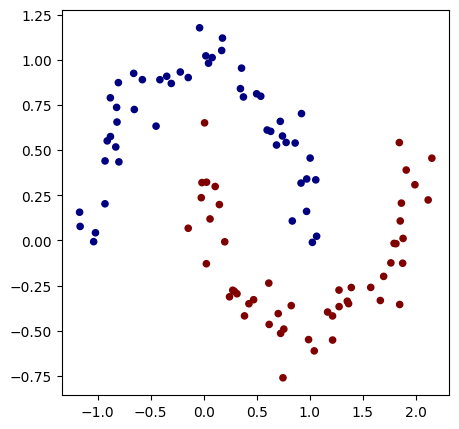

In [15]:
from sklearn.datasets import make_moons, make_blobs
X, y = make_moons(n_samples=100, noise=0.1, random_state=1)

y = y * 2 - 1 # make y be -1 or 1
# visualize in 2D
plt.figure(figsize=(5, 5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

# initialize a model
model = MLP(2, [16, 16, 1]) # 2-layer neural network
print(model)
print("number of parameters", len(model.parameters()))

# loss function
def loss(batch_size=None):

    # inline DataLoader :)
    if batch_size is None:
        Xb, yb = X, y
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[ri], y[ri]
    inputs = [list(map(Value, xrow)) for xrow in Xb]

    # forward the model to get scores
    scores = list(map(model, inputs))

    # svm "max-margin" loss
    losses = [(1 - yi * scorei).relu() for yi, scorei in zip(yb, scores)]
    data_loss = sum(losses) * (1.0 / len(losses))
    # L2 regularization
    alpha = 1e-4
    reg_loss = alpha * sum((p*p for p in model.parameters()))
    total_loss = data_loss + reg_loss

    # also get accuracy
    accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)]
    return total_loss, sum(accuracy) / len(accuracy)

total_loss, acc = loss()
print(total_loss, acc)

In [17]:
# optimization

model = MLP(2, [16, 16, 1]) # 2-layer neural network

for k in range(10):

    model.zero_grad() # обнуляем градиенты с предыдущего шага

    # forward
    total_loss, acc = loss()

    # backward
    total_loss.backward() # вычисляем новые значения градиентов

    learning_rate = 0.1

    # шаг оптимизации
    # update (sgd)
    for p in model.parameters():
        p.data = p.data - learning_rate * p.grad

    if k % 1 == 0:
        print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%")


step 0 loss 1.0002265746105072, accuracy 59.0%
step 1 loss 1.0001205016301895, accuracy 62.0%
step 2 loss 0.9999876847742359, accuracy 62.0%
step 3 loss 0.9998710537586308, accuracy 66.0%
step 4 loss 0.999762311402387, accuracy 66.0%
step 5 loss 0.9996617723345645, accuracy 69.0%
step 6 loss 0.9995756625450464, accuracy 70.0%
step 7 loss 0.9995051665967436, accuracy 74.0%
step 8 loss 0.9994480500572197, accuracy 74.0%
step 9 loss 0.999395488139486, accuracy 78.0%


(-1.7609251085622153, 1.9890748914377847)

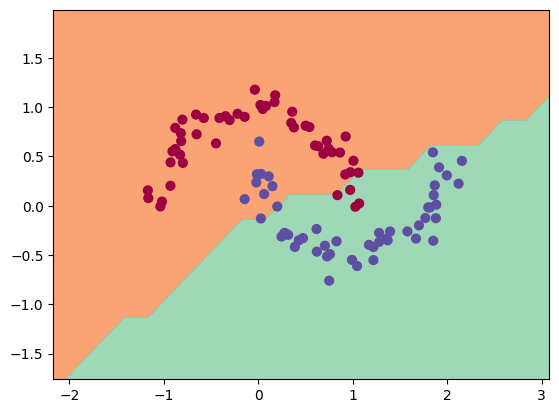

In [11]:
=# visualize decision boundary

h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = list(map(model, inputs))
Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

# Блиц

В каждой ячейке есть закомментированный ответ на вопрос. Можете сделать самопроверку.


## Зачем нужны ф-ии активации?

<!-- Ф-ии активации вносят нелинейность, помогает моделировать сложные взаимодействия. Если не применять нелинейности, то сеть превратится в последовательность линейных преобразований, но в этом бы не было смысла, тк последовательность линейных преобразований --- можно заменить одним линейным преобразованием, в этом нет сложных зависимостей. -->



## Зачем нужен autograd?

<!-- Чтобы не считать градиенты вручную. Если разложить сеть на копозицию простых операций, то зная производные простых операций, с помощью chain rule можно получить градиенты итоговой ф-ии. -->


## Зачем вычисляются градиенты?

<!-- Чтобы обновить параметры сети. Сеть -- это сложная ф-я $ F(x, p) $, параметры которой мы будем оптимизировать -->


## Какие градиенты нам действительно нужны? Ради чего мы делаем backward pass?

<!--
Сеть -- это сложная ф-я $ F(x, p) $

Обычно градиенты параметров ($p$) нейросети. В процессе вычисления графа мы так же получаем градиенты для промежуточных звеньев (вершины sum, mul из лекции), но они нужны только для того, чтобы получить градиенты параметров сети.

Но на самом деле, так же можно посчитать градиенты и по входным данным ($x$). Это тоже иногда используется

-->



## Когда вычисляются градиенты?

Варианты ответа:

* forward pass
* backward pass
* во время шага оптимизации

<!-- Во время backward pass'а -->


## Что происходит с градииентом вершины во время backward pass, если во время forward pass через вершину было 2 прохода?

<!-- Градиенты суммируются -->



## Как граф, построенный во время `forward pass` используется во время `backward pass`?

<!-- Для вычислениия частных производных :)

Для графа из лекции (продублирован в начале семинара) для вершины mul

\begin{align*}
f &= q z  \\
\frac {\partial f} {\partial q} &= z
\end{align*} -->

## Расставьте этапы обучения модели в правильном порядке

* обновление весов сети
* backward pass
* forward pass + вычисление лосса
* обнуление градиентов `model.zero_grad()`

<!--

Правильный порядок:

* обнуление градиентов `model.zero_grad()`
* forward pass + вычисление лосса
* backward pass
* обновление весов сети

Так правильным будет такой вариант:

* forward pass + вычисление лосса
* обнуление градиентов `model.zero_grad()`
* backward pass
* обновление весов сети

На самом деле, возможны и некоторые другие варианты. Но важно, чтобы перед backward было обнуление градиентов модели.

 -->

## Как умножение веса на `0.1` повлияет на градиент этого веса?

<!-- Уменьшит его в 10 раз. -->


----

PS

Варианты построения графа вычислений:

1. Явно создавать граф вычислений (tensorflow 1.x):

    ```
    x, y, z = placeholder(), placeholder(), placeholder()
    f = (x+y)*z
    grad_x, grad_y, grad_z = gradients(f, [x, y, z])

    print(f) # <operation: mul>
    print(grad_x) # <operation: mul>

    out, fx = graph.run([f, grad_x], {x: 1, y: 2, z: -3})
    print(out, fx) # -9, -3
    ```

2. Упражняться в ООП и писать код (pytorch/tensorflow 2.x):

    ```
    x, y, z = Variable(1), Variable(2), Variable(-3)
    f = (x + y) * z
    print(f) # -9
    f.backward()
    print(x.grad) # -3
    ```

Пойдем по второму пути.
